# Sold houses in the UK analysis

### Load required libraries

In [1]:
library(tmap)
library(plotly)
library(ggthemes)
library(leaflet)
library(ggmap)
library(rgdal)
library(rgeos)
library(maptools)
library(spdep)
library(ggplot2)
library(sqldf)

Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘ggmap’

The following object is masked from ‘package:plotly’:

    wind

Loading required package: sp
rgdal: version: 1.2-8, (SVN revision 663)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.2, released 2017/09/15
 Path to GDAL shared files: /usr/share/gdal/2.2
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-3 
rgeos version: 0.3-21, (SVN revision 540)
 GEOS runtime version: 3.5.1-CAPI-1.9.1 r4246 
 Linking to sp version: 1.2-3 
 Polygon checking: TRUE 

Checking rgeos availability: TRUE
Loading required package: Matrix
Loading required package: gs

### Load aggregated sold house prices data

In [2]:
require(RJDBC)

path2JDBCDriver = "/usr/local/hive/hive-jdbc-uber-2.6.1.0-129.jar"
connectionURL = "jdbc:hive2://egs2hstlhdpkx01.network.uk.ad:8443/;ssl=true;transportMode=HTTP;httpPath=gateway/hive2/hive"
myUserName = 'garciaj'
myPassword = '1990Supersissoko3'

driver = JDBC(driverClass = "org.apache.hive.jdbc.HiveDriver", path2JDBCDriver)
conn = dbConnect(driver, connectionURL, myUserName, myPassword)
res = dbGetQuery(conn, "SELECT * FROM  retdb_propdb_dev.data_sold_properties_raw_aggr")

colnames(res) = gsub("data_sold_properties_raw_aggr.","",colnames(res))
head(res)

dbDisconnect(conn)

Loading required package: RJDBC
Loading required package: rJava


lsoa_code,lsoa_name,date_sale_transfer,number_houses_sold,avg_price,min_price,max_price,stddev_price
E01000001,City of London 001A,1995,62,114152.06,44257,210000,42938.10
E01000002,City of London 001B,1995,47,157175.53,16500,450000,91077.23
E01000003,City of London 001C,1995,33,77000.52,35000,120000,21523.53
E01000005,City of London 001E,1995,2,61000.00,55000,67000,6000.00
E01000006,Barking and Dagenham 016A,1995,8,68124.38,52000,79995,8236.78
E01000007,Barking and Dagenham 015A,1995,4,59541.50,36000,80000,20195.88


[1] TRUE

In [3]:
house_prices = res

### Load LSOA shapefile

In [4]:
lsoa = readOGR("/home/DS/DE/Lookup/UK_Shapefiles_Census_Boundaries_data/Data Sources/infuse_lsoa_lyr_2011_clipped/infuse_lsoa_lyr_2011_clipped.shp")
lsoa$geo_code = as.character(lsoa$geo_code)
lsoa$geo_label = as.character(lsoa$geo_label)
lsoa$geo_labelw = NULL

OGR data source with driver: ESRI Shapefile 
Source: "/home/DS/DE/Lookup/UK_Shapefiles_Census_Boundaries_data/Data Sources/infuse_lsoa_lyr_2011_clipped/infuse_lsoa_lyr_2011_clipped.shp", layer: "infuse_lsoa_lyr_2011_clipped"
with 42619 features
It has 3 fields


In [5]:
print('Head of geo_code from LSOA shapefile')
print(head(lsoa$geo_code))
print('')
print('Head of geo_label from LSOA shapefile')
print(head(lsoa$geo_label))

[1] "Head of geo_code from LSOA shapefile"
[1] "E01009784" "W01001500" "E01016357" "E01031084" "E01002906" "E01027840"
[1] ""
[1] "Head of geo_label from LSOA shapefile"
[1] "Dudley 009B"                 "Torfaen 011D"               
[3] "Reading 008B"                "Nuneaton and Bedworth 004D" 
[5] "Kensington and Chelsea 002C" "Scarborough 002C"           


### Join LSOA shapefile and the aggregated house price data

In following sections, we will calculate the spatial distribution of prices. In order to do that, we will need a spatial polygon data frame R object which can be used in the tmap package. 

* Because we will want to understand distribution of prices, we will need this sp-data-frame contaning the price data.
* The current loaded shapefile (lsoa), only has the names of the polygons, but no prices.
* We can perform an inner join with the "house_prices_[YEAR]" dataset to append the prices as a new parameter of the sp-data-frame.
* The "house_prices_[YEAR]" dataset is not directly the house prices table we loaded at the beggining for a simple reason:
    * A sp-data-frame cannot have duplicated names for a polygon. In other words, each individual polygon must have discrete and unique different sets of parameters (in this case, geo_code and geo_name).
    * If we perform a join based on unique geo_code names with a non-unique lsoa_code from the house prices dataset, then we will throw an error.
    * Therefore, what we can do is create multiple year datasets, and get the average of the whole year for each unique geo_code. 

In [6]:
for(i in unique(house_prices$date_sale_transfer)){
    print(paste("Creating polygon shapefile with averge prices for year",i))
    
    house_prices_year = house_prices %>% filter(date_sale_transfer == i) %>% group_by(lsoa_code, lsoa_name) %>% dplyr::summarize(avg_price = mean(avg_price, na.rm = TRUE))
    house_prices_year = as.data.frame(house_prices_year)
    LSOA.house_prices = merge(x = lsoa
                              , y = house_prices_year
                              , by.x = c("geo_code")
                              , by.y = c("lsoa_code")
                             )
    LSOA.house_prices = LSOA.house_prices[-which(is.na(LSOA.house_prices$avg_price)),]
    
    assign(paste0("LSOA.house_prices_",i),LSOA.house_prices)
}

[1] "Creating polygon shapefile with averge prices for year 1995"
[1] "Creating polygon shapefile with averge prices for year 1996"
[1] "Creating polygon shapefile with averge prices for year 1997"
[1] "Creating polygon shapefile with averge prices for year 1998"
[1] "Creating polygon shapefile with averge prices for year 1999"
[1] "Creating polygon shapefile with averge prices for year 2000"
[1] "Creating polygon shapefile with averge prices for year 2001"
[1] "Creating polygon shapefile with averge prices for year 2002"
[1] "Creating polygon shapefile with averge prices for year 2003"
[1] "Creating polygon shapefile with averge prices for year 2004"
[1] "Creating polygon shapefile with averge prices for year 2005"
[1] "Creating polygon shapefile with averge prices for year 2006"
[1] "Creating polygon shapefile with averge prices for year 2007"
[1] "Creating polygon shapefile with averge prices for year 2008"
[1] "Creating polygon shapefile with averge prices for year 2009"
[1] "Creat

In [7]:
print(class(LSOA.house_prices_1997))
print(class(LSOA.house_prices_2004))
print(class(LSOA.house_prices_2008))
print(class(LSOA.house_prices_2013))

[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"
[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"
[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"
[1] "SpatialPolygonsDataFrame"
attr(,"package")
[1] "sp"


In [8]:
head(LSOA.house_prices_1999[,c("geo_code","geo_label","avg_price")])

,geo_code,geo_label,avg_price
10377,E01009784,Dudley 009B,59671.74
42172,W01001500,Torfaen 011D,60768.40
16769,E01016357,Reading 008B,90973.47
31187,E01031084,Nuneaton and Bedworth 004D,44021.49
3732,E01002906,Kensington and Chelsea 002C,154725.00
28016,E01027840,Scarborough 002C,60996.67


In [10]:
head(LSOA.house_prices_2011[,c("geo_code","geo_label","avg_price")])

,geo_code,geo_label,avg_price
10377,E01009784,Dudley 009B,149626.0
42172,W01001500,Torfaen 011D,120385.7
16769,E01016357,Reading 008B,171454.5
31187,E01031084,Nuneaton and Bedworth 004D,136524.0
3732,E01002906,Kensington and Chelsea 002C,520656.2
28016,E01027840,Scarborough 002C,201014.5


### Calculating/Loading Spatial neighbouring shapefiles

In following sections, we will calculate the spatial distribution of prices. In order to do that, we first need to calculate the polygons that neighbour each other. You can either:

* Recalculate the neighbouring polyongs running the section label as "Run to calculate"
* Load the data which has been calculated in the past running the section labeled as "Run to re-load".

These options are here to use as the recalculation step does take a fair amount of time to calculate. We encourage load the data unless we know the LSOA shapefile has changed dramatically.

##### Run to calculate

all_nb = poly2nb(lsoa, queen=TRUE, row.names = lsoa$geo_code)
saveRDS(all_nb, file = '/home/DS/DE/Lookup/UK_Shapefiles_Census_Boundaries_data/Data Sources/infuse_lsoa_lyr_2011_clipped/polygon_neighbours.RData')

##### Run to re-load

In [73]:
lsoa_nb = readRDS(file = '/home/DS/DE/Lookup/UK_Shapefiles_Census_Boundaries_data/Data Sources/infuse_lsoa_lyr_2011_clipped/polygon_neighbours.RData')
lsoa_nb

Neighbour list object:
Number of regions: 42619 
Number of nonzero links: 246998 
Percentage nonzero weights: 0.01359837 
Average number of links: 5.79549 
11 regions with no links:
E01019077 S01007324 S01007284 S01007310 S01011827 S01011830 S01011831 S01011832 S01012403 S01012413 S01012414

# Running the first global autocorrelation example: Wandsworth and Lambeth

The goal of runnig this example is to check if our calculations make sense with a small defined area. If they do, then we can apply the same actions to the whole dataset.

####  Subset for Wandsworth

In [49]:
LSOA.house_prices_example_2011 = LSOA.house_prices_2011[c(grep("Wandsworth",LSOA.house_prices_2011$geo_label)
                                                          ,grep("Lambeth",LSOA.house_prices_2011$geo_label)),]

#### Plot of the quantiles for average price in Wandsworth area 2001

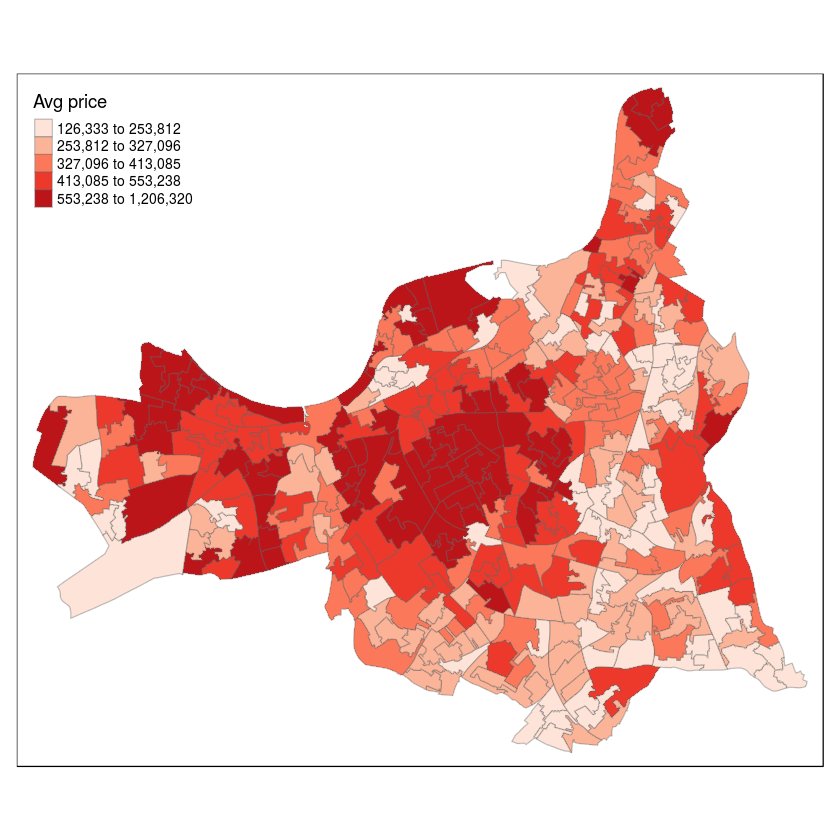

In [50]:
options(repr.plot.width=7)
tm_shape(LSOA.house_prices_example_2011) + tm_fill("avg_price"
                                            , palette = "Reds"
                                            , style = "quantile"
                                            , title = "Avg price") + tm_borders(alpha=.4)

#### Convert the poly + neighbours data to a listw object

In [52]:
listw2 = nb2listw(poly2nb(LSOA.house_prices_example_2011
                          , queen=TRUE
                          , row.names = LSOA.house_prices_example_2011$geo_code)
                  , zero.policy=TRUE
                  , style = "W")

#### Run a local Moran test

* Ii      -> local moran statistic
* E.Ii	  -> expectation of local moran statistic
* Var.Ii  -> variance of local moran statistic
* Z.Ii	  -> standard deviate of local moran statistic
* Pr()	  -> p-value of local moran statistic


In [53]:
local = localmoran(x = LSOA.house_prices_example_2011$avg_price, listw = listw2)
head(local)

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z > 0)
E01004589,0.79461057,-0.002816901,0.1622823,1.97950069,2.387983e-02
E01004505,-0.02124411,-0.002816901,0.1210232,-0.05296942,5.211219e-01
E01004542,3.98198923,-0.002816901,0.1622823,9.89171650,2.261033e-23
E01033135,0.41901082,-0.002816901,0.2448004,0.85256800,1.969495e-01
E01004600,0.01735379,-0.002816901,0.2448004,0.04076755,4.837406e-01
E01004585,0.21685966,-0.002816901,0.1622823,0.54531593,2.927681e-01


#### Binds results to our polygon shapefile

In [54]:
moran.map = cbind(LSOA.house_prices_example_2011, local)
head(moran.map)

,geo_code,geo_label,lsoa_name,avg_price,Ii,E.Ii,Var.Ii,Z.Ii,Pr.z...0.
5367,E01004589,Wandsworth 009E,Wandsworth 009E,642687.1,0.79461057,-0.002816901,0.1622823,1.97950069,2.387983e-02
5285,E01004505,Wandsworth 014D,Wandsworth 014D,466594.1,-0.02124411,-0.002816901,0.1210232,-0.05296942,5.211219e-01
5322,E01004542,Wandsworth 021D,Wandsworth 021D,855334.5,3.98198923,-0.002816901,0.1622823,9.89171650,2.261033e-23
33175,E01033135,Wandsworth 010G,Wandsworth 010G,545565.9,0.41901082,-0.002816901,0.2448004,0.85256800,1.969495e-01
5378,E01004600,Wandsworth 018C,Wandsworth 018C,292359.8,0.01735379,-0.002816901,0.2448004,0.04076755,4.837406e-01
5363,E01004585,Wandsworth 008D,Wandsworth 008D,508676.2,0.21685966,-0.002816901,0.1622823,0.54531593,2.927681e-01


#### Maps the results

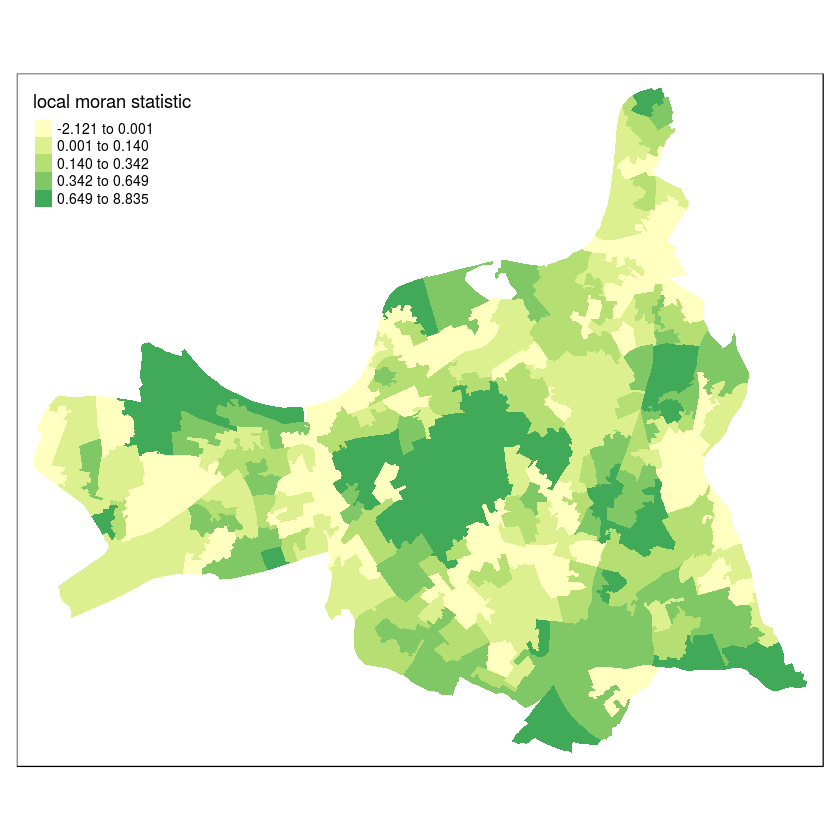

In [55]:
tm_shape(moran.map) + tm_fill(col = "Ii", style = "quantile", title = "local moran statistic")

### Clustering the Moran statistic and the Average prices together

* From the moran map, it is possible to observe the variations in autocorrelation across space. We can interpret that there seems to be a geographic pattern to the autocorrelation. However, it is not possible to understand if these are clusters of high or low values.

* Why not try to make a map of the P-value to observe variances in significance across Wandsworth? Use names(moran.map@data) to find the column headers.

* One thing we could try to do is to create a map which labels the features based on the types of relationships they share with their neighbours (i.e. high and high, low and low, insignificant, etc…)

#### Create a vector of 0s with length equal to the lsoa_codes

In [56]:
quadrant = vector(mode="numeric", length=nrow(local))
LSOA.house_prices_example_2011$quadrant_numeric = quadrant

#### Center the variable of interest around its mean

In [57]:
m.avg_price = LSOA.house_prices_example_2011$avg_price - mean(LSOA.house_prices_example_2011$avg_price)
LSOA.house_prices_example_2011$avg_price_around_mean = LSOA.house_prices_example_2011$avg_price - mean(LSOA.house_prices_example_2011$avg_price)

#### Center the local Moran's around the mean

In [58]:
m.local = local[,1] - mean(local[,1])
LSOA.house_prices_example_2011$local_moran_stat = local[,1]
LSOA.house_prices_example_2011$local_moran_stat_around_mean = local[,1] - mean(local[,1])

#### Assigning value groups

Now we assign 5 different groups comparing both the variable of interest and the local moran statistic. The idea is to identify groups of clusters. For example: if the avg price is higher than average and also has a high correlation with it's neighbours, we have found a cluster of high value.

In [59]:
# local area price above average price of borough & local moran stat above average local moran stat - highest value
quadrant[LSOA.house_prices_example_2011$avg_price_around_mean > 0 
         & LSOA.house_prices_example_2011$local_moran_stat_around_mean > 0] = 4

# local area price above average price of borough & local moran stat above average local moran stat - mid highest value.
quadrant[LSOA.house_prices_example_2011$avg_price_around_mean > 0 
         & LSOA.house_prices_example_2011$local_moran_stat_around_mean < 0] = 3

# local area price below average price of borough & local moran stat above average local moran stat - mid lowest value.
quadrant[LSOA.house_prices_example_2011$avg_price_around_mean < 0 
         & LSOA.house_prices_example_2011$local_moran_stat_around_mean > 0] = 2

# local area price below average price of borough & local moran stat below average local moran stat - lowest value
quadrant[LSOA.house_prices_example_2011$avg_price_around_mean < 0 
         & LSOA.house_prices_example_2011$local_moran_stat_around_mean < 0] = 1

#### Significance threshold

* This is used to detect insignificant areas based on the p-values we have from local moran statistic. The lower the significance level the more restrictive and sure we will be about our results.
* We assign a 0 to anything that is not statistically significant

In [60]:
signif = 0.1
quadrant[local[,5]>signif] = 0

LSOA.house_prices_example_2011$quadrant_numeric = quadrant
LSOA.house_prices_example_2011$quadrant_category = ifelse(LSOA.house_prices_example_2011$quadrant_numeric == 0, 'Statistically insignificant'
                                                   , ifelse(LSOA.house_prices_example_2011$quadrant_numeric == 1, 'Area price below average - Negatively correlated with neighbouring areas'
                                                            , ifelse(LSOA.house_prices_example_2011$quadrant_numeric == 2, 'Area price below average - Positively correlated with neighbouring areas'
                                                                     , ifelse(LSOA.house_prices_example_2011$quadrant_numeric == 3, 'Area price above average - Negatively correlated with neighbouring areas'
                                                                              , ifelse(LSOA.house_prices_example_2011$quadrant_numeric == 4, 'Area price above average - Positively correlated with neighbouring areas'
                                                                                       ,LSOA.house_prices_example_2011$quadrant_numeric
                                                                              )))))

table(LSOA.house_prices_example_2011$quadrant_category)


Area price above average - Negatively correlated with neighbouring areas 
                                                                       1 
Area price above average - Positively correlated with neighbouring areas 
                                                                      45 
Area price below average - Negatively correlated with neighbouring areas 
                                                                       2 
Area price below average - Positively correlated with neighbouring areas 
                                                                      43 
                                             Statistically insignificant 
                                                                     265 

#### Plot in R

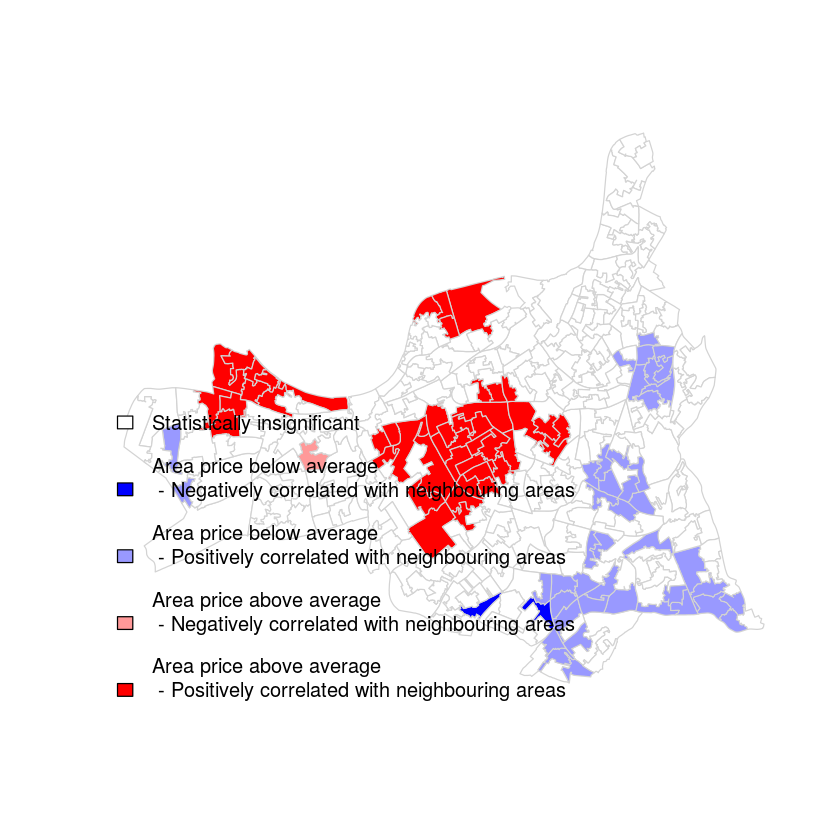

In [61]:
brks = c(0,1,2,3,4)
colors = c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(LSOA.house_prices_example_2011, border="lightgray", col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
legend("bottomleft",legend=c("Statistically insignificant"
                             ,"Area price below average \n - Negatively correlated with neighbouring areas \n"
                             ,"Area price below average \n - Positively correlated with neighbouring areas \n"
                             ,"Area price above average \n - Negatively correlated with neighbouring areas \n"
                             ,"Area price above average \n - Positively correlated with neighbouring areas \n"),
       fill=colors,bty="n")

# Create a function with the necessary steps to calculate the values groups

In [88]:
global_value_groups_function = function(df, year_df){

    # Convert the poly + neighbours data to a listw object
    print("(1/9) Convert the poly + neighbours data to a listw object")
    listw2 = nb2listw(poly2nb(df
                              , queen=TRUE
                              , row.names = df$geo_code)
                      , zero.policy=TRUE
                      , style = "W")   
    
    # Run a local Moran test
    print("(2/9) Run a local Moran test")
    local = localmoran(x = df$avg_price, listw = listw2, na.action = na.omit, zero.policy=TRUE)
        
    # Binds results to our polygon shapefile
    print("(3/9) Binds results to our polygon shapefile")
    moran.map = cbind(df, local)
                                            
    # Center the variable of interest around its mean
    print("(4/9) Center the variable of interest around its mean")
    m.avg_price = df$avg_price - mean(df$avg_price)
    df$avg_price_around_mean = df$avg_price - mean(df$avg_price)
    
    # Center the local Moran's around the mean 
    print("(5/9) Center the local Moran's around the mean ")
    m.local = local[,1] - mean(local[,1])
    df$local_moran_stat = local[,1]
    df$local_moran_stat_around_mean = local[,1] - mean(local[,1])  
    
    # Create a vector of 0s with length equal to the lsoa_codes
    print("(6/9) Create a vector of 0s with length equal to the lsoa_codes")
    quadrant = vector(mode="numeric", length=nrow(local))
    df$quadrant_numeric = quadrant
                      
    # Assigning value groups
    print("(7/9) Assigning value groups")
    quadrant[df$avg_price_around_mean > 0 
         & df$local_moran_stat_around_mean > 0] = 4

    quadrant[df$avg_price_around_mean > 0 
         & df$local_moran_stat_around_mean < 0] = 3

    quadrant[df$avg_price_around_mean < 0 
         & df$local_moran_stat_around_mean > 0] = 2

    quadrant[df$avg_price_around_mean < 0 
         & df$local_moran_stat_around_mean < 0] = 1  
                      
    # Significance threshold
    print("(8/9) Statistical Significance threshold")
    signif = 0.1
    quadrant[local[,5]>signif] = 0

    df$quadrant_numeric = quadrant
    df$global_quadrant_category = ifelse(df$quadrant_numeric == 0, 'Statistically insignificant'
                                    , ifelse(df$quadrant_numeric == 1, 'Area price below average - Negatively correlated with neighbouring areas = Very poor'
                                            , ifelse(df$quadrant_numeric == 2, 'Area price below average - Positively correlated with neighbouring areas = Poor'
                                                    , ifelse(df$quadrant_numeric == 3, 'Area price above average - Negatively correlated with neighbouring areas = Very rich'
                                                            , ifelse(df$quadrant_numeric == 4, 'Area price above average - Positively correlated with neighbouring areas = Rich'
                                                                        ,df$quadrant_numeric
                                                                                  )))))
    print("(9/9) Final results")
    print(table(df$global_quadrant_category))
    
    df$year = year_df

    return(df)
}

#### Checking the function works

In [63]:
test_df = value_groups_function(df = LSOA.house_prices_example_2011)

[1] "(1/9) Convert the poly + neighbours data to a listw object"
[1] "(2/9) Run a local Moran test"
[1] "(3/9) Binds results to our polygon shapefile"
[1] "(4/9) Create a vector of 0s with length equal to the lsoa_codes"
[1] "(5/9) Center the variable of interest around its mean"
[1] "(6/9) Center the local Moran's around the mean "
[1] "(7/9) Assigning value groups"
[1] "(8/9) Significance threshold"
[1] "(9/9) Final results"

Area price above average - Negatively correlated with neighbouring areas 
                                                                       1 
Area price above average - Positively correlated with neighbouring areas 
                                                                      45 
Area price below average - Negatively correlated with neighbouring areas 
                                                                       2 
Area price below average - Positively correlated with neighbouring areas 
                                                  

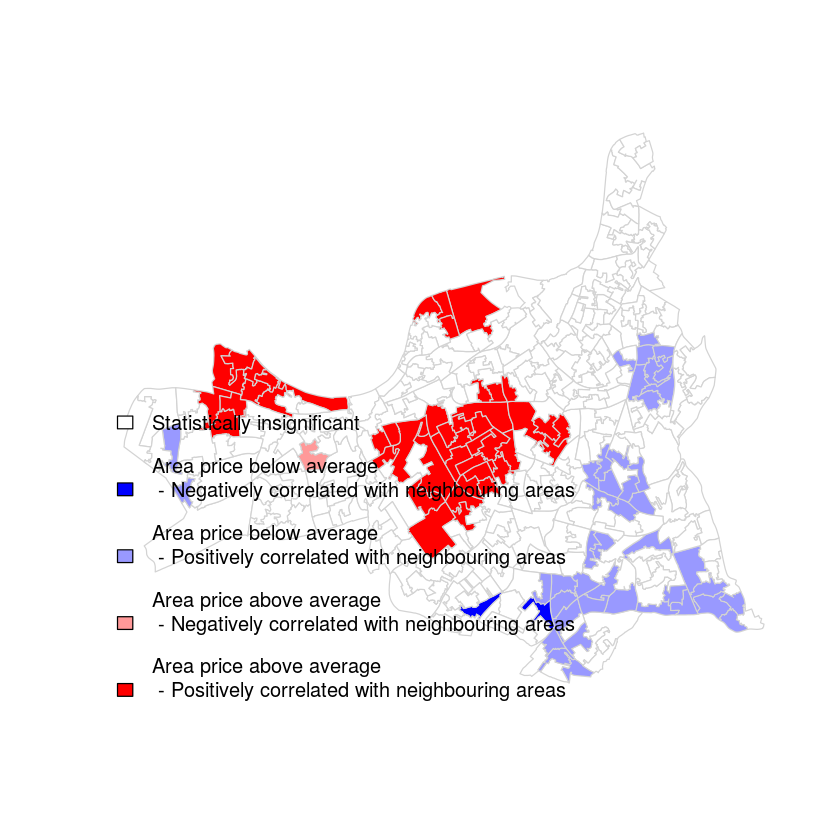

In [64]:
brks = c(0,1,2,3,4)
colors = c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(test_df, border="lightgray", col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
legend("bottomleft",legend=c("Statistically insignificant"
                             ,"Area price below average \n - Negatively correlated with neighbouring areas = Very poor \n"
                             ,"Area price below average \n - Positively correlated with neighbouring areas = Poor \n"
                             ,"Area price above average \n - Negatively correlated with neighbouring areas = Very Rich \n"
                             ,"Area price above average \n - Positively correlated with neighbouring areas = Rich \n"),
       fill=colors,bty="n")

# Running global autocorrelation for the full LSOA and the differents years

In [92]:
print("house_prices_1995")
LSOA.house_prices_1995_sp = global_value_groups_function(df = LSOA.house_prices_1995, year_df = 1995)

print("house_prices_1996")
LSOA.house_prices_1996_sp = global_value_groups_function(df = LSOA.house_prices_1996, year_df = 1996)

print("house_prices_1997")
LSOA.house_prices_1997_sp = global_value_groups_function(df = LSOA.house_prices_1997, year_df = 1997)

print("house_prices_1998")
LSOA.house_prices_1998_sp = global_value_groups_function(df = LSOA.house_prices_1998, year_df = 1998)

print("house_prices_1999")
LSOA.house_prices_1999_sp = global_value_groups_function(df = LSOA.house_prices_1999, year_df = 1999)

print("house_prices_2000")
LSOA.house_prices_2000_sp = global_value_groups_function(df = LSOA.house_prices_2000, year_df = 2000)

print("house_prices_2001")
LSOA.house_prices_2001_sp = global_value_groups_function(df = LSOA.house_prices_2001, year_df = 2001)

print("house_prices_2002")
LSOA.house_prices_2002_sp = global_value_groups_function(df = LSOA.house_prices_2002, year_df = 2002)

print("house_prices_2003")
LSOA.house_prices_2003_sp = global_value_groups_function(df = LSOA.house_prices_2003, year_df = 2003)

print("house_prices_2004")
LSOA.house_prices_2004_sp = global_value_groups_function(df = LSOA.house_prices_2004, year_df = 2004)

print("house_prices_2005")
LSOA.house_prices_2005_sp = global_value_groups_function(df = LSOA.house_prices_2005, year_df = 2005)

print("house_prices_2006")
LSOA.house_prices_2006_sp = global_value_groups_function(df = LSOA.house_prices_2006, year_df = 2006)

print("house_prices_2007")
LSOA.house_prices_2007_sp = global_value_groups_function(df = LSOA.house_prices_2007, year_df = 2007)

print("house_prices_2008")
LSOA.house_prices_2008_sp = global_value_groups_function(df = LSOA.house_prices_2008, year_df = 2008)

print("house_prices_2009")
LSOA.house_prices_2009_sp = global_value_groups_function(df = LSOA.house_prices_2009, year_df = 2009)

print("house_prices_2010")
LSOA.house_prices_2010_sp = global_value_groups_function(df = LSOA.house_prices_2010, year_df = 2010)

print("house_prices_2011")
LSOA.house_prices_2011_sp = global_value_groups_function(df = LSOA.house_prices_2011, year_df = 2011)

print("house_prices_2012")
LSOA.house_prices_2012_sp = global_value_groups_function(df = LSOA.house_prices_2012, year_df = 2012)

print("house_prices_2013")
LSOA.house_prices_2013_sp = global_value_groups_function(df = LSOA.house_prices_2013, year_df = 2013)

print("house_prices_2014")
LSOA.house_prices_2014_sp = global_value_groups_function(df = LSOA.house_prices_2014, year_df = 2014)

print("house_prices_2015")
LSOA.house_prices_2015_sp = global_value_groups_function(df = LSOA.house_prices_2015, year_df = 2015)

print("house_prices_2016")
LSOA.house_prices_2016_sp = global_value_groups_function(df = LSOA.house_prices_2016, year_df = 2016)

print("house_prices_2017")
LSOA.house_prices_2017_sp = global_value_groups_function(df = LSOA.house_prices_2017, year_df = 2017)

[1] "house_prices_1995"
[1] "(1/9) Convert the poly + neighbours data to a listw object"
[1] "(2/9) Run a local Moran test"
[1] "(3/9) Binds results to our polygon shapefile"
[1] "(4/9) Center the variable of interest around its mean"
[1] "(5/9) Center the local Moran's around the mean "
[1] "(6/9) Create a vector of 0s with length equal to the lsoa_codes"
[1] "(7/9) Assigning value groups"
[1] "(8/9) Statistical Significance threshold"
[1] "(9/9) Final results"

Area price above average - Negatively correlated with neighbouring areas = Very rich 
                                                                                 477 
     Area price above average - Positively correlated with neighbouring areas = Rich 
                                                                                3626 
Area price below average - Negatively correlated with neighbouring areas = Very poor 
                                                                                1154 
     Area price 

#### Example outputs

In [93]:
head(as.data.frame(LSOA.house_prices_2008_sp))

,geo_code,geo_label,lsoa_name,avg_price,avg_price_around_mean,local_moran_stat,local_moran_stat_around_mean,quadrant_numeric,global_quadrant_category,year
10377,E01009784,Dudley 009B,Dudley 009B,144997.8,-75783.526,0.23736755,-0.4566466,0,Statistically insignificant,2008
42172,W01001500,Torfaen 011D,Torfaen 011D,154850.0,-65931.356,0.16046346,-0.5335507,0,Statistically insignificant,2008
16769,E01016357,Reading 008B,Reading 008B,230214.0,9432.644,-0.01270352,-0.7067177,0,Statistically insignificant,2008
31187,E01031084,Nuneaton and Bedworth 004D,Nuneaton and Bedworth 004D,142135.5,-78645.876,0.36044284,-0.3335713,0,Statistically insignificant,2008
3732,E01002906,Kensington and Chelsea 002C,Kensington and Chelsea 002C,362187.5,141406.144,1.77291769,1.0789035,4,Area price above average - Positively correlated with neighbouring areas = Rich,2008
28016,E01027840,Scarborough 002C,Scarborough 002C,200365.6,-20415.736,0.03165862,-0.6623556,0,Statistically insignificant,2008


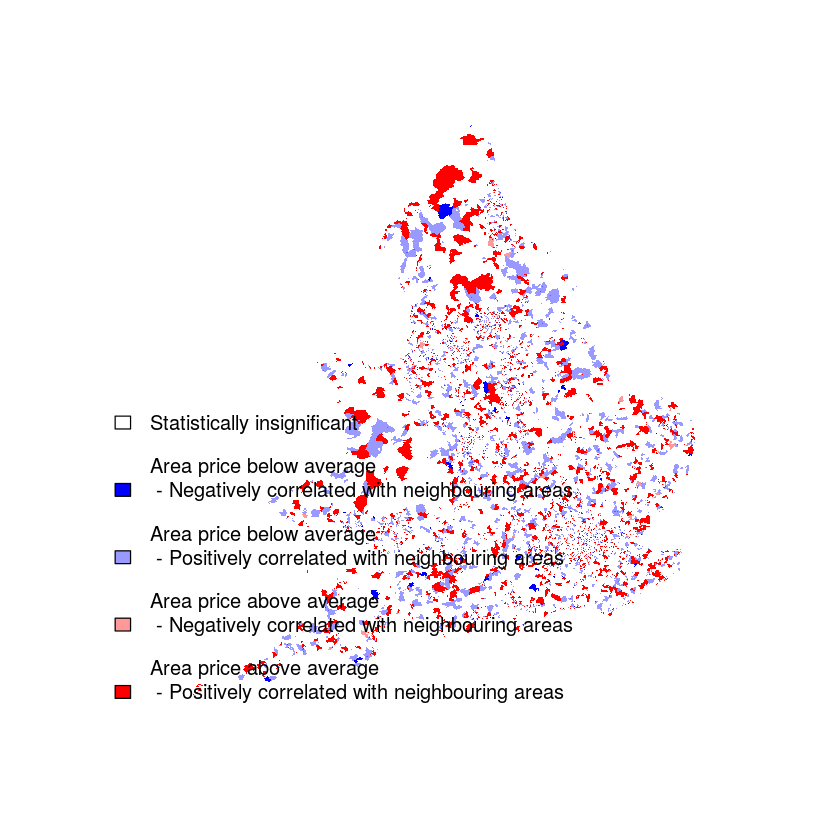

In [84]:
brks = c(0,1,2,3,4)
colors = c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(LSOA.house_prices_2008_sp, border=NA, col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
legend("bottomleft",legend=c("Statistically insignificant"
                             ,"Area price below average \n - Negatively correlated with neighbouring areas = Very poor \n"
                             ,"Area price below average \n - Positively correlated with neighbouring areas = Poor \n"
                             ,"Area price above average \n - Negatively correlated with neighbouring areas = Very Rich \n"
                             ,"Area price above average \n - Positively correlated with neighbouring areas = Rich \n"),
       fill=colors,bty="n")

## Joining all years together

In [94]:
houses_prices_global_distribution = rbind(as.data.frame(LSOA.house_prices_1995_sp)
                                         , as.data.frame(LSOA.house_prices_1996_sp)
                                         , as.data.frame(LSOA.house_prices_1997_sp)
                                         , as.data.frame(LSOA.house_prices_1998_sp)
                                         , as.data.frame(LSOA.house_prices_1999_sp)
                                         , as.data.frame(LSOA.house_prices_2000_sp)
                                         , as.data.frame(LSOA.house_prices_2001_sp)
                                         , as.data.frame(LSOA.house_prices_2002_sp)
                                         , as.data.frame(LSOA.house_prices_2003_sp)
                                         , as.data.frame(LSOA.house_prices_2004_sp)
                                         , as.data.frame(LSOA.house_prices_2005_sp)
                                         , as.data.frame(LSOA.house_prices_2006_sp)
                                         , as.data.frame(LSOA.house_prices_2007_sp)
                                         , as.data.frame(LSOA.house_prices_2008_sp)
                                         , as.data.frame(LSOA.house_prices_2009_sp)
                                         , as.data.frame(LSOA.house_prices_2010_sp)
                                         , as.data.frame(LSOA.house_prices_2011_sp)
                                         , as.data.frame(LSOA.house_prices_2012_sp)
                                         , as.data.frame(LSOA.house_prices_2013_sp)
                                         , as.data.frame(LSOA.house_prices_2014_sp)
                                         , as.data.frame(LSOA.house_prices_2015_sp)
                                         , as.data.frame(LSOA.house_prices_2016_sp)
                                         , as.data.frame(LSOA.house_prices_2017_sp))

In [95]:
head(houses_prices_global_distribution)

,geo_code,geo_label,lsoa_name,avg_price,avg_price_around_mean,local_moran_stat,local_moran_stat_around_mean,quadrant_numeric,global_quadrant_category,year
10377,E01009784,Dudley 009B,Dudley 009B,58528.60,-6843.444,0.082057083,-0.5865976,0,Statistically insignificant,1995
42172,W01001500,Torfaen 011D,Torfaen 011D,52107.14,-13264.904,0.096767450,-0.5718872,0,Statistically insignificant,1995
16769,E01016357,Reading 008B,Reading 008B,56827.69,-8544.354,0.087442423,-0.5812122,0,Statistically insignificant,1995
31187,E01031084,Nuneaton and Bedworth 004D,Nuneaton and Bedworth 004D,35188.10,-30183.944,0.446357152,-0.2222975,0,Statistically insignificant,1995
3732,E01002906,Kensington and Chelsea 002C,Kensington and Chelsea 002C,122363.64,56991.596,2.020734585,1.3520799,4,Area price above average - Positively correlated with neighbouring areas = Rich,1995
28016,E01027840,Scarborough 002C,Scarborough 002C,52316.22,-13055.824,-0.008282529,-0.6769372,0,Statistically insignificant,1995


## Saving the dataset

In [96]:
write.csv(houses_prices_global_distribution
          , '/home/DS/DE/Lookup/Land_registry_data/land_registry_spatial_distribution.csv'
          , quote = TRUE
          , row.names = FALSE)

# Running the first local autocorrelation example: Wandsworth and Lambeth

The global autocorrelation process we ran above is very biased towards London and urban areas. Why is this?

* If we consider the whole of the UK as what we want to analyse and understand in terms of spatial distribution, then London, with super high prices compared to the rest of the UK, will be pretty much always with a quadrant of "Area price above average - Positively correlated with neighbouring areas"
* Lets buils a local autocorrelation and check the differences between both for a specific area